In [1]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

In [2]:
# 2. Đọc file csv và gắn index với giá Price
df = pd.read_csv('pre_BTC-USD.csv')
df = df.rename(columns={'Close': 'Price'})
df1 = df.reset_index()['Price']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2285 entries, 0 to 2284
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2285 non-null   object 
 1   Open       2285 non-null   float64
 2   High       2285 non-null   float64
 3   Low        2285 non-null   float64
 4   Price      2285 non-null   float64
 5   Adj Close  2285 non-null   float64
 6   Volume     2285 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 125.1+ KB


In [3]:
# 3. Scaler data
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

In [4]:
# 4. Chia train test 8 - 2
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

# Lấy dữ liệu train và test
train_data = df1[:train_size]
test_data = df1[train_size:]

print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)

Train shape: (1828, 1)
Test shape: (457, 1)


In [5]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [6]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
combined_data = np.concatenate((train_data[-time_step:], test_data))
X_test, ytest = create_dataset(combined_data, time_step)

In [7]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [8]:
# 8. Define RNN Model
model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [9]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, validation_data=(X_test, ytest), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
27/27 [==============================] - 2s 38ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 2/100
27/27 [==============================] - 1s 20ms/step - loss: 5.9696e-04 - val_loss: 8.6823e-04
Epoch 3/100
27/27 [==============================] - 1s 22ms/step - loss: 5.7671e-04 - val_loss: 0.0010
Epoch 4/100
27/27 [==============================] - 0s 17ms/step - loss: 5.3872e-04 - val_loss: 5.8111e-04
Epoch 5/100
27/27 [==============================] - 0s 17ms/step - loss: 4.1681e-04 - val_loss: 6.2821e-04
Epoch 6/100
27/27 [==============================] - 0s 17ms/step - loss: 3.7695e-04 - val_loss: 5.4650e-04
Epoch 7/100
27/27 [==============================] - 0s 18ms/step - loss: 4.4007e-04 - val_loss: 5.0805e-04
Epoch 8/100
27/27 [==============================] - 1s 29ms/step - loss: 3.8130e-04 - val_loss: 4.7803e-04
Epoch 9/100
27/27 [==============================] - 0s 16ms/step - loss: 4.0031e-04 - val_loss: 4.5735e-04
Epoch 10/100
27/27 [====================

In [10]:
# 10. Dự báo dữ liệu test
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)

15/15 [==============================] - 0s 5ms/step


In [11]:
# 11. Chuẩn hóa dữ liệu y_pred
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)

In [12]:
# 12. Tính RMSE, MAPE, MAE
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

mae = mean_absolute_error(ytest, y_pred)
mape = mean_absolute_percentage_error(ytest, y_pred)
rmse = np.sqrt(mean_squared_error(ytest, y_pred))

print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape * 100)
print("Root Mean Square Error (RMSE):", rmse)

Mean Absolute Error (MAE): 39408.14876995289
Mean Absolute Percentage Error (MAPE): 7665900.582715941
Root Mean Square Error (RMSE): 42174.6448493787


In [13]:
# 13. Hàm dự báo
def forecast_days(n_days):
    x_input = test_data[-100:].reshape(1, -1)
    temp_input = list(x_input[0])

    lst_output = []
    i = 0
    while i < n_days:
        if len(temp_input) > 100:
            x_input = np.array(temp_input[1:])
            x_input = x_input.reshape(1, -1)
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

In [14]:
# 14. Dự báo 30, 60, 90 ngày tiếp theo
forecast_30 = forecast_days(30)
forecast_60 = forecast_days(60)
forecast_90 = forecast_days(90)

In [15]:
# 15. In ra dự đoán cho 30 ngày tiếp theo
print("Dự báo cho 30 ngày tiếp theo:", forecast_30)

Dự báo cho 30 ngày tiếp theo: [[0.9181546568870544], [0.9006795883178711], [0.8942704796791077], [0.8909125924110413], [0.8835239410400391], [0.8687830567359924], [0.8643010258674622], [0.861541211605072], [0.8515884280204773], [0.8494152426719666], [0.8403239846229553], [0.8320891261100769], [0.8250534534454346], [0.8262559175491333], [0.8187090158462524], [0.81606125831604], [0.8070178031921387], [0.8003865480422974], [0.7985060214996338], [0.7925533056259155], [0.7917238473892212], [0.7854819893836975], [0.7819601893424988], [0.7739738821983337], [0.7740834355354309], [0.7684260606765747], [0.7646500468254089], [0.7624035477638245], [0.7572402954101562], [0.752022922039032]]


In [16]:
# 15. In ra dự đoán cho 60 ngày tiếp theo
print("Dự báo cho 60 ngày tiếp theo:", forecast_60)

Dự báo cho 60 ngày tiếp theo: [[0.9181546568870544], [0.9006795883178711], [0.8942704796791077], [0.8909125924110413], [0.8835239410400391], [0.8687830567359924], [0.8643010258674622], [0.861541211605072], [0.8515884280204773], [0.8494152426719666], [0.8403239846229553], [0.8320891261100769], [0.8250534534454346], [0.8262559175491333], [0.8187090158462524], [0.81606125831604], [0.8070178031921387], [0.8003865480422974], [0.7985060214996338], [0.7925533056259155], [0.7917238473892212], [0.7854819893836975], [0.7819601893424988], [0.7739738821983337], [0.7740834355354309], [0.7684260606765747], [0.7646500468254089], [0.7624035477638245], [0.7572402954101562], [0.752022922039032], [0.7509275674819946], [0.7502200603485107], [0.7441536784172058], [0.7385647296905518], [0.7373356223106384], [0.7352871894836426], [0.7308856844902039], [0.7288210391998291], [0.7254190444946289], [0.7207506895065308], [0.7188142538070679], [0.7168185114860535], [0.7137309312820435], [0.7099020481109619], [0.70

In [17]:
# 15. In ra dự đoán cho 90 ngày tiếp theo
print("Dự báo cho 90 ngày tiếp theo:", forecast_90)

Dự báo cho 90 ngày tiếp theo: [[0.9181546568870544], [0.9006795883178711], [0.8942704796791077], [0.8909125924110413], [0.8835239410400391], [0.8687830567359924], [0.8643010258674622], [0.861541211605072], [0.8515884280204773], [0.8494152426719666], [0.8403239846229553], [0.8320891261100769], [0.8250534534454346], [0.8262559175491333], [0.8187090158462524], [0.81606125831604], [0.8070178031921387], [0.8003865480422974], [0.7985060214996338], [0.7925533056259155], [0.7917238473892212], [0.7854819893836975], [0.7819601893424988], [0.7739738821983337], [0.7740834355354309], [0.7684260606765747], [0.7646500468254089], [0.7624035477638245], [0.7572402954101562], [0.752022922039032], [0.7509275674819946], [0.7502200603485107], [0.7441536784172058], [0.7385647296905518], [0.7373356223106384], [0.7352871894836426], [0.7308856844902039], [0.7288210391998291], [0.7254190444946289], [0.7207506895065308], [0.7188142538070679], [0.7168185114860535], [0.7137309312820435], [0.7099020481109619], [0.70

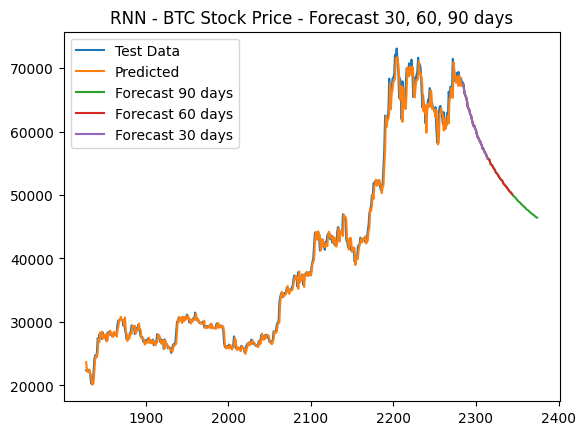

In [18]:
# 16. Vẽ hình

# Vẽ dữ liệu kiểm tra
test_data_index = pd.RangeIndex(start=train_size, stop=train_size + test_size)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test Data')

# Vẽ dữ liệu dự đoán
plt.plot(np.arange(train_size, train_size + len(y_pred)), y_pred, label='Predicted')

# Vẽ dự báo 90, 60, 30 ngày
plt.plot(np.arange(train_size + len(test_data), train_size + len(test_data) + len(forecast_90)), scaler.inverse_transform(forecast_90), label='Forecast 90 days')
plt.plot(np.arange(train_size + len(test_data), train_size + len(test_data) + len(forecast_60)), scaler.inverse_transform(forecast_60), label='Forecast 60 days')
plt.plot(np.arange(train_size + len(test_data), train_size + len(test_data) + len(forecast_30)), scaler.inverse_transform(forecast_30), label='Forecast 30 days')

plt.title('RNN - BTC Stock Price - Forecast 30, 60, 90 days')
plt.legend()
plt.show()
